COPYRIGHT NOTICE
In the name of Christ our Lord be blessed. We, Joshuah Rainstar(joshuah.rainstar@gmail.com), do claim copyright to this code, or software, and associated documentation, as our work in the year 2025 Anno Domini, reserving all rights and assigning them in accordance with the following license terms:

1. Permission is by our authority and with this statement granted, to any person or artificial intelligence without limitation or restriction to examine, analyze, read, dissect, translate, use, modify, and distribute the aforementioned copyrighted items, subject to the following conditions:
2. This license must be included in full with any copies or works containing substantial portions of the copyrighted items.
3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.


THE COPYRIGHTED ITEMS ARE PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE COPYRIGHTED ITEMS OR THEIR USE OR ANY OTHER CIRCUMSTANCES CONCERNING THEM.


this is an experimental model intended to elucidate possible mechanics for attention across sequences in addition to tokenwise. it is reasonably fast and efficient. conceptually, the design was envisioned by me and coded through refinement with OpenAI Codex Orion One and chatgpt

"hierarchical multi-scale transformer with MoE-like sparse selection"

SelfScalableTanh from  Self-scalable Tanh (Stan): Faster Convergence and Better Generalization in Physics-informed Neural Networks
https://arxiv.org/abs/2204.1258
Motivation: my gut said its a good idea. Impact: little bit faster convergence even in gpt9
harmonic loss from  Harmonic Loss Trains Interpretable AI Models
https://arxiv.org/abs/2502.01628note that I do the math in log space to avoid explosions
note that harmonic loss has been swapped for a student's t distribution to avoid NaN collapses near zero
motivation: interpretable model. Impact: speeds up convergence even more than harmonic!

XOR from  Two-argument activation functions learn soft XOR operations like cortical neurons
https://arxiv.org/abs/2110.06871note that my implementation is a differential XOR for backprop capability
motivation: little bit of internal reasoning maybe? Impact: slows down convergence somewhat

WOLF optimizer experimental by me, it may not beat adam but it is simpler than adam, closer to SGD with some smoothing of integration
impact: speeds up convergence somewhat for early iterations and will not NAN from high LR.
probable benefit- switch optimizers after model drops. could be good for bigger models.. maybe

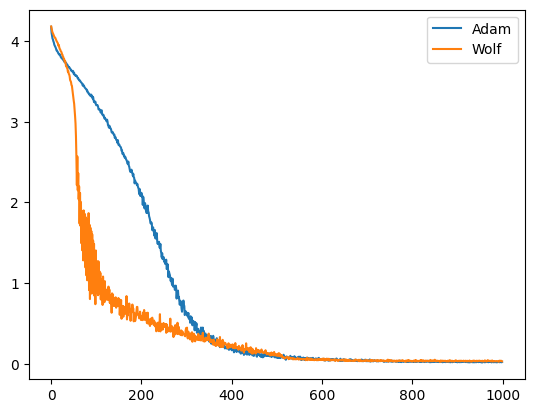
m 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
import math
import requests

In [2]:
from torch.optim.optimizer import Optimizer
class Wolf(Optimizer):
    """Implements Wolf algorithm."""
    def __init__(self, params, lr=0.25, betas=(0.9, 0.999), eps=1e-8):
        # Define default parameters
        defaults = dict(lr=lr, betas=betas, eps=eps)
        self.lr = lr
        # Initialize the parent Optimizer class first
        super().__init__(params, defaults)
        # Constants specific to Wolf
        # Initialize state for each parameter
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['p'] = torch.zeros_like(p)  # Second moment estimate


    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step and adjusts dropout in transformer blocks."""
        etcerta = 0.367879441  # Constant used in update rule
        et = 1 - etcerta
    
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
    
        # Iterate over parameter groups.
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad
    
                #  AMP Compatibility: Check for NaN or Inf in gradients
                if torch.isnan(grad).any() or torch.isinf(grad).any():
                    print("Skipping parameter update due to NaN/Inf gradient.")
                    continue  # Skip this update if the gradient has NaN or Inf
    
                state = self.state[p]
                exp_avg = state['p']
    
                # Compute update and update second moment-like state.
                update = exp_avg * et + grad * etcerta
                state['p'] = exp_avg * et + update * etcerta
    
                # Compute sign agreement between update and gradient.
                sign_agreement = torch.sign(update) * torch.sign(grad)
    
                # Where the signs agree (mask is True), update the parameter.
                mask = (sign_agreement > 0)
                adaptive_alpha = group.get('lr', self.lr)
                p.data = torch.where(mask, p.data - adaptive_alpha * update, p.data)
    
                # AMP Compatibility: Ensure a step counter is updated
                state['step'] = state.get('step', 0) + 1  # Track optimization steps
    
        return loss

   
def student_t_unembedding(hidden_states, unembedding, df=2.718281828459, eps=1e-9, placeholder_idx=None):
    """
    Student's t-based unembedding with optional placeholder modification.
    
    Arguments:
      hidden_states: (B, S, D)  => model’s output embeddings (hidden state)
      unembedding:   (D, V)    => learnable "word vectors" (unembedding matrix)
      df (float): degrees of freedom for the Student's t distribution
      eps (float): numerical epsilon to avoid log(0) and div-by-zero
      placeholder_idx (int, optional): if provided, indicates the column in the unembedding
          corresponding to the placeholder token. The distances for that token will be adjusted 
          using an adaptive noise factor.
    
    Returns:
      p: (B, S, V)  probability distribution over V vocabulary tokens.
    """
    B, S, D = hidden_states.shape
    V = unembedding.shape[1]

    # Expand hidden => (B, S, 1, D)
    x_expanded = hidden_states.unsqueeze(2)
    # Expand unembedding => (1, 1, V, D)
    w_expanded = unembedding.t().unsqueeze(0).unsqueeze(0)  # shape: (1, 1, V, D)
    
    # Compute squared Euclidean distance between each hidden vector and each unembedding vector.
    dist_sq = torch.sum((x_expanded - w_expanded) ** 2, dim=-1).clamp(min=1e-6)  # (B, S, V)
        
    # Compute the negative energy:
    #    E = 0.5*(df + D) * log(1 + dist_sq / df)
    # and so log probability (up to an additive constant) is:
    #    log_p = -E
    log_p_unnorm = -0.5 * (df + D) * torch.log1p(dist_sq / df)  # (B, S, V)
    
    # Normalize via log_softmax over the vocabulary dimension.
    log_p = F.log_softmax(log_p_unnorm, dim=-1)  # (B, S, V)
    p = log_p.exp()
    return p

# ---------------------------------------------------
# Custom Activation
# ---------------------------------------------------
class ReferenceActivation(nn.Module):
    def __init__(self, gamma=24):
        super().__init__()
        self.gamma = gamma

    def forward(self, x):
        log_x = torch.sign(x) * torch.log1p(torch.abs(x))
        return log_x / torch.sqrt(1 + self.gamma * log_x ** 2)


class TapeHeadBlock(nn.Module):
    def __init__(self, chunk_size, embed_dim,vocab_size, num_heads=1, placeholder_idx=None, dropout=0.1):
        super().__init__()
        self.chunk_size = chunk_size
        self.embed_dim = embed_dim

        # Chunk-based attention
        self.chunk_proj = nn.Linear(chunk_size * embed_dim, embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.ln_attn = nn.LayerNorm(embed_dim)

        # MLP
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            ReferenceActivation(),
            nn.LayerNorm(4 * embed_dim),

            nn.Linear(4 * embed_dim, embed_dim),
            nn.Dropout(dropout),
        )
        self.ln_mlp = nn.LayerNorm(embed_dim)

        # Unembedding for this block
        self.unembedding = nn.Parameter(torch.randn(embed_dim, vocab_size))
        nn.init.kaiming_uniform_(self.unembedding, a=math.sqrt(5))

        # **Logits Attention Layer**: Learns to selectively use past logits
        self.logits_attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.placeholder_idx = placeholder_idx
    def forward(self, x, h, logits):
        """
        x:      (B, S, D) original input
        h:      (B, S, D) current hidden state
        logits: (B, S, V) probability distribution from previous block

        Returns:
          x: same input
          h: updated hidden state
          logits: refined probability distribution
        """
        # 1) Chunk-based attention
        attn_out = self._chunk_attention(h)  # (B, S, D)
        h_attn = self.ln_attn(h + attn_out)  # residual + LN

        # 2) Convert logits into an embedding (if logits exist)
        if logits is not None:
            vocab_embedding = torch.matmul(logits, self.unembedding.T)  # (B, S, D)

            # **Learnable Cross-Attention Over Logits**
            query = h_attn
            key = vocab_embedding
            value = vocab_embedding
            logits_context, _ = self.logits_attention(query, key, value)

            # Merge the logits-based signal into h
            h_attn = h_attn + logits_context  # Now it's conditioned on past logits

        # 3) MLP processing
        h_mlp = self.ln_mlp(h_attn + self.mlp(h_attn))

        # 4) Compute new logits
        logits = student_t_unembedding(h_mlp, self.unembedding,placeholder_idx=self.placeholder_idx)

        return x, h_mlp, logits  # Pass refined logits forward


    def _chunk_attention(self, h):
        """ Chunk-based self-attention """
        B, S, D = h.shape
        c = self.chunk_size

        # Move feature dim before sequence (B, D, S)
        x_3d = h.permute(0, 2, 1)

        # Right-pad so we can slide windows of size c up to the last token
        x_3d_padded = F.pad(x_3d, (0, c - 1))

        # Unfold => (B, D*c, S)
        unfolded = F.unfold(x_3d_padded.unsqueeze(-1), kernel_size=(c, 1), stride=(1, 1))
        unfolded = unfolded.transpose(1, 2)  # => (B, S, D*c)

        # Project => (B, S, D)
        chunk_tensor = self.chunk_proj(unfolded)

        # Self-attention
        out, _ = self.attn(chunk_tensor, chunk_tensor, chunk_tensor)
        return out

class TapeHead(nn.Module):
    """
    A Transformer-like block with progressive chunk sizes.
    Each layer inside the TapeHead doubles the chunk size.
    """
    def __init__(self, embed_dim, vocab_size, num_layers=3, base_chunk=1, num_heads=2, placeholder_idx=None,dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.base_chunk = base_chunk

        # Create progressively larger TapeHeadBlocks
        self.blocks = nn.ModuleList([
            TapeHeadBlock(
                chunk_size=base_chunk * (2 ** i),  # 1, 2, 4, 8, ...
                embed_dim=embed_dim,vocab_size=vocab_size,
                num_heads=num_heads,placeholder_idx=placeholder_idx,
                dropout=dropout
            )
            for i in range(num_layers)
        ])

    def forward(self, x, h,logits):
        """
        x: (B, S, D) original input
        h: (B, S, D) hidden state

        Returns:
          x: original input (unchanged)
          h: final refined hidden state
        """
        for block in self.blocks:
            x, h, logits = block(x, h, logits)  # Process each block progressively
        return x, h ,logits 

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-8):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.eps = eps

    def forward(self, x):
        return x / (x.norm(2, dim=-1, keepdim=True) + self.eps) * self.weight
        
class TapeTransformer(nn.Module):
    """
    Full GPT-like model with:
      - Token + Position Embeddings
      - Multiple stacked TapeHeads
      - XOR applied to each TapeHead output
      - Final Student-t unembedding
    """
    def __init__(self, vocab_size, seq_len=128,chunk_len=4, embed_dim=128, num_heads=2, num_layers=4, placeholder_idx=None, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.embed_dim = embed_dim

        # Token & Positional Embeddings
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.pos_emb = nn.Parameter(torch.zeros(1, seq_len, embed_dim))
        num_chunk_layers = math.ceil(math.log2(chunk_len))  # Computes the exponent of the next power of 2

        # New: LayerNorm applied right after the embeddings
        self.embed_ln = nn.LayerNorm(embed_dim)

        # Stacked TapeHeads and corresponding XOR modules
        self.tape_heads = nn.ModuleList([
            TapeHead(embed_dim, vocab_size=vocab_size, num_layers=num_chunk_layers, base_chunk=1, num_heads=num_heads,placeholder_idx=placeholder_idx, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.final_norm = RMSNorm(embed_dim)
        self.logits_norm = nn.LayerNorm(embed_dim)

        self.norm_gate = nn.Parameter(torch.tensor(0.5))  # Start at 0.5 for balanced effect

        # Final Student-t unembedding
        self.final_ln = nn.LayerNorm(embed_dim)
        self.logits_weight = nn.Parameter(torch.tensor(0.5))  # Initialized to 0.5, learnable scalar
        self.unembedding = nn.Parameter(torch.randn(embed_dim, vocab_size))
        nn.init.kaiming_uniform_(self.unembedding, a=math.sqrt(5))

    def forward(self, x):
        """
        x: (B, S) integer token IDs
        Returns:
          p_final: (B, S, V) final probability distribution
        """
        x = x.unsqueeze(0) if x.ndim == 1 else x  # Ensure batch dimension

        B, S = x.shape
        assert S <= self.seq_len, "Sequence too long."

        # 1) Token + Positional Embeddings
        h = self.token_emb(x) + self.pos_emb[:, :S, :]  # (B, S, D)
        h = self.embed_ln(h)  # NEW: Apply LayerNorm right after embeddings to ensure stability

        logits = None
        
        # 2) Pass through TapeHeads and apply XOR after each
        for head in self.tape_heads:
            x, h, logits = head(x, h,logits)
            
        p_final = student_t_unembedding(h, self.unembedding, df=2.718281828459, eps=1e-9,placeholder_idx=placeholder_idx)

        return p_final




In [3]:
import gc,torch

gc.collect()
torch.cuda.empty_cache()

In [4]:
# ====================================================
# Data Preparation (Shakespeare)
# ====================================================
def load_shakespeare_text():
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    text = requests.get(url).text
    return text

text = load_shakespeare_text()
chars = sorted(list(set(text)))

# Add a placeholder token: an ASCII grey block (visible in output)
placeholder = "▒"  # Choose your preferred grey block character
if placeholder not in chars:
    chars.append(placeholder)
    chars.sort()  # Ensure ordering is maintained

vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
placeholder_idx = stoi[placeholder]
print("Placeholder token for even vocab size:", placeholder, "with index:", placeholder_idx)


def encode(s):
    return [stoi[c] for c in s]

def decode(l):
    return ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)

def get_batch(batch_size, seq_len):
    ix = torch.randint(0, data.size(0) - seq_len - 1, (batch_size,))
    x = torch.stack([data[i:i+seq_len] for i in ix])
    y = torch.stack([data[i+1:i+seq_len+1] for i in ix])
    return x, y
    

# ====================================================
# Training Setup
# ====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TapeTransformer(
    vocab_size=vocab_size,  # example
    seq_len=256,
    chunk_len=4,
    embed_dim=256,#heads times true vocab, round up 
    num_layers=8,
    num_heads=4,
    placeholder_idx=placeholder_idx,
    dropout=0 #cannot use dropout, tooo slow
).to(device)

optimizer = Wolf(model.parameters(), lr=0.3678)

scaler = GradScaler()

num_epochs = 100
batch_size = 16
seq_len = 256 #from karapathy
eps = 1e-8

loss_history = []
state_dict = torch.load("model_dict_216_225.pth")
model.load_state_dict(state_dict)


Placeholder token for even vocab size: ▒ with index: 65


<All keys matched successfully>

In [128]:
max(math.log(vocab_size/(2+16)),0)

1.2992829841302609

In [5]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

18828034

In [225]:
import torch
import math
from collections import deque


# Training control variables
seq_len = 2  # Start with the smallest sequence
max_seq_len = 256
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Loss tracking
loss_history = []  # Store all losses
epochs_per_check = 10  # Print every 10 epochs
target_loss = max(math.log(vocab_size/(seq_len+1)),0)

while seq_len <= max_seq_len:
    total_loss = 0.0
    step_count = 0

    # Training loop for current sequence length
    for epoch in range(100):
        model.train()
        x_batch, targets = get_batch(batch_size, seq_len)
        x_batch, targets = x_batch.to(device), targets.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            preds = model(x_batch)
            gathered_probs = torch.gather(preds, -1, targets.unsqueeze(-1)).squeeze(-1)
            base_loss = -torch.log(gathered_probs + 1e-16)
            final_loss = base_loss.mean()

        scaler.scale(final_loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        # Track loss & progress
        loss_val = final_loss.item()
        loss_history.append(loss_val)
        total_loss += loss_val
        step_count += 1
        if not epoch % 1000:
            print(loss_val,seq_len)


    # Decision: Increase seq_len if avg loss < threshold
    seq_len += 1


4.723278999328613 2
2.326223373413086 3
1.8994555473327637 4
1.3370016813278198 5
0.6056818962097168 6
0.5713168978691101 7
0.4374990463256836 8
0.3548830449581146 9
0.2261609584093094 10
0.25166812539100647 11
0.26560360193252563 12
0.2430911362171173 13
0.17985926568508148 14
0.16421592235565186 15
0.13121363520622253 16
0.1830933839082718 17
0.13790637254714966 18
0.1260160505771637 19
0.13295947015285492 20
0.11980137228965759 21
0.13427695631980896 22
0.07401202619075775 23
0.14200130105018616 24
0.09801565855741501 25
0.10621458292007446 26
0.0989280566573143 27
0.07234808802604675 28
0.08363618701696396 29
0.06319288164377213 30
0.05313081666827202 31
0.06808671355247498 32
0.06340193003416061 33
0.08577441424131393 34
0.06544764339923859 35
0.0589059479534626 36
0.053894367069005966 37
0.054200246930122375 38
0.07342959940433502 39
0.07336612045764923 40
0.04927349463105202 41
0.05451706424355507 42
0.044729724526405334 43
0.046857722103595734 44
0.06348446011543274 45
0.043106

KeyboardInterrupt: 

In [ ]:
for epoch in range(1000000):
        model.train()
        x_batch, targets = get_batch(batch_size, 256)
        x_batch, targets = x_batch.to(device), targets.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            preds = model(x_batch)
            gathered_probs = torch.gather(preds, -1, targets.unsqueeze(-1)).squeeze(-1)
            base_loss = -torch.log(gathered_probs + 1e-16)
            final_loss = base_loss.mean()

        scaler.scale(final_loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        # Track loss & progress
        loss_val = final_loss.item()
        loss_history.append(loss_val)
        print(loss_val)

0.009856050834059715
0.008584938943386078
0.010900353081524372
0.009557952173054218
0.008415843360126019
0.009721972979605198
0.009341489523649216
0.008129240013659
0.007575596682727337
0.00978936068713665
0.0068056173622608185
0.01155703142285347
0.009352175518870354
0.009955303743481636
0.009657113812863827
0.009384965524077415
0.013828913681209087
0.009505216032266617
0.009108872152864933
0.006791351828724146
0.008747464045882225
0.005944461561739445
0.009159301407635212
0.008960890583693981
0.009410623461008072
0.008687897585332394
0.007771106902509928
0.010085010901093483
0.00895774271339178
0.007820510305464268
0.008677255362272263
0.009867753833532333
0.009784572757780552
0.008502332493662834
0.010864307172596455
0.010727165266871452
0.010079965926706791
0.010349185205996037
0.008892253041267395
0.007471131626516581
0.01056732889264822
0.009274356998503208
0.008538286201655865
0.011307922191917896
0.008775121532380581
0.008944605477154255
0.006953865755349398
0.01066716946661472

In [235]:
save_path = 'model_dict_216_225.pth'

# Save the model's state_dict
torch.save(model.state_dict(), save_path)


In [236]:
torch.save(model, "full_model_structure_216_225.pth")

In [237]:
optimizer = Wolf(model.parameters(), lr=0.3678)


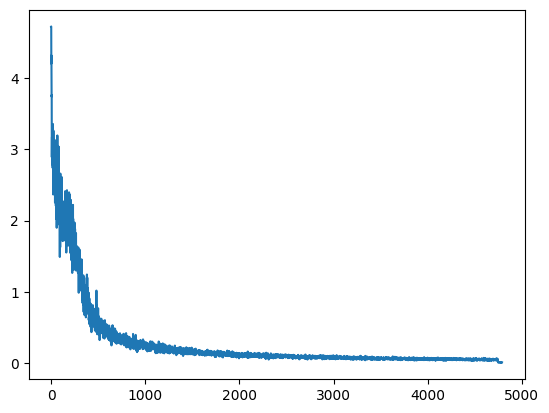

In [232]:
plt.plot(loss_history)

In [231]:
# ====================================================
# Evaluation: Text Generation
# ====================================================

model.eval()
with torch.no_grad():
    prompt = "oh Romeo! Romeo!"
    context = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    generated = context
    for _ in range(200):  # Generate 200 tokens.
        inp = generated[:, -seq_len:]
        p = model(inp)  # p: (B, seq, vocab_size)
        last_token_probs = p[:, -1, :]  # Shape: [batch_size, vocab_size]
        predicted_token = torch.multinomial(last_token_probs, num_samples=1)

        #next_token = torch.multinomial(last_token_probs, num_samples=1)
        generated = torch.cat((generated, predicted_token), dim=1)
    sample = decode(generated[0].cpu().tolist())
    print("Generated Sample:\n", sample)


Generated Sample:
 oh Romeo! Romeo!

Kray, OMHHEMET:
Thy, eave weay, do an
Than sethort a howd norms no'llorchou a her bok Dor ble's onth sonss ont itis, wiser cheald horr;
Of.
So is
OUTMintruitaveld th I th he thy, my nows LOasek thun
